### U-net with simple Resnet Blocks v2, can get 0.80+
* Original version : 
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
        
        
#### update log
1.   Cancel last dropout (seems better)
2.  modify convolution_block, to be more consistant with the standard resent model. 
      * https://arxiv.org/abs/1603.05027
3. Use faster  IOU metric score code,
      * https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric
4. Use  binary_crossentropy loss and then Lovász-hinge loss (very slow!)
     * Lovász-hinge loss: https://github.com/bermanmaxim/LovaszSoftmax
     
Limit the max epochs number to make the kernel finish in the limit of 6 hours, better score can be achived at more epochs 

In [3]:
!pip3 install tqdm

In [2]:
!pip3 install keras

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

from multiGPUCheckPointCallback import MultiGPUCheckpointCallback

from Eve import Eve

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
version = 7
basic_name = './models/Unet_resnet_v{0}'.format(version)
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

./models/Unet_resnet_v7.model
./models/Unet_resnet_v7.csv


In [3]:
img_size_ori = 101
img_size_target = 101
n_features = 1

path_train = './train'
path_test = './test'

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("./train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./depths.csv", index_col="id")

In [5]:
depths_norm_df = (depths_df - depths_df.mean()) / depths_df.std()
#depths_norm_df = (depths_df - depths_df.min()) / (depths_df.max() - depths_df.min())

depths_df = depths_norm_df

In [6]:
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [7]:
train_df["images"] = [np.array(load_img(path_train + "/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/envs/py3env/lib/python3.5/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [8]:
train_df["masks"] = [np.array(load_img(path_train + "/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

/usr/local/envs/py3env/lib/python3.5/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [9]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


Text(0.5,0,'Coverage class')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


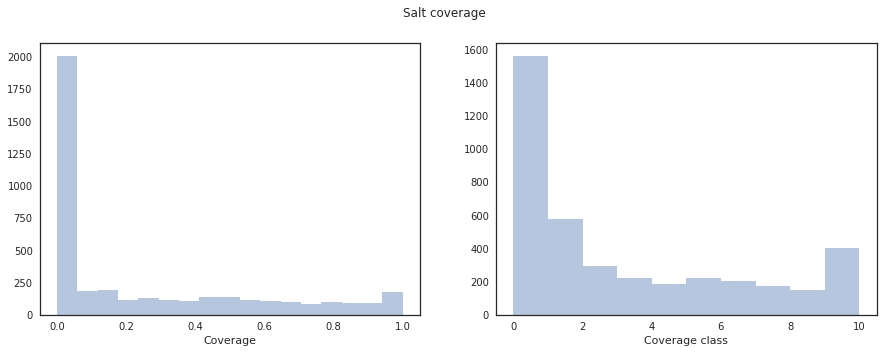

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


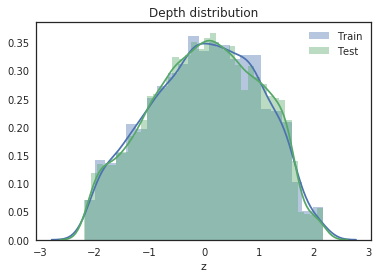

In [11]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [12]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [13]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


In [14]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [15]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [16]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [17]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [37]:
# model
gpu_count = 4
with tf.device("/cpu:0"):
    input_layer = Input((img_size_target, img_size_target, 1))
    #input_features = Input((n_features, ), name='feat')
    output_layer = build_model(input_layer, 16, 0.5)

model = Model(input_layer, output_layer)

if gpu_count > 1:
    base_model = model
    model = multi_gpu_model(model, gpus=gpu_count)

#c = optimizers.SGD(lr = 0.01)
#c = optimizers.adam(lr = 0.01)
c = optimizers.Nadam(lr = 0.005)
#c = Eve(lr = 0.001)
model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])
#model.compile(loss=[focal_loss(alpha=.25, gamma=2)], optimizer=c, metrics=[my_iou_metric])

#model.summary()

In [38]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)

if gpu_count > 1:
    model_checkpoint = MultiGPUCheckpointCallback(save_model_name, base_model, monitor='my_iou_metric', 
                                       mode = 'max', save_best_only=True, verbose=1)
else:
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                       mode = 'max', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
batch_size = 32
epochs = 100

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size * gpu_count,
                    callbacks=[ model_checkpoint, reduce_lr],
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 73s 11ms/step - loss: 0.5294 - my_iou_metric: 0.1685 - val_loss: 0.5023 - val_my_iou_metric: 0.1870
Epoch 00001: my_iou_metric improved from -inf to 0.16848, saving model to ./models/Unet_resnet_v7.model
Epoch 2/100
6400/6400 [==============================] - 28s 4ms/step - loss: 0.4072 - my_iou_metric: 0.3638 - val_loss: 0.8749 - val_my_iou_metric: 0.3909
Epoch 00002: my_iou_metric improved from 0.16848 to 0.36378, saving model to ./models/Unet_resnet_v7.model
Epoch 3/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.3780 - my_iou_metric: 0.4152 - val_loss: 0.4131 - val_my_iou_metric: 0.2956
Epoch 00003: my_iou_metric improved from 0.36378 to 0.41522, saving model to ./models/Unet_resnet_v7.model
Epoch 4/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.3504 - my_iou_metric: 0.4810 - val_loss: 0.3763 - val_my_iou_metric: 0.4203
Epoch 0000

6400/6400 [==============================] - 27s 4ms/step - loss: 0.1419 - my_iou_metric: 0.6822 - val_loss: 0.1556 - val_my_iou_metric: 0.7114
Epoch 00034: my_iou_metric improved from 0.67191 to 0.68222, saving model to ./models/Unet_resnet_v7.model
Epoch 35/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.1417 - my_iou_metric: 0.6833 - val_loss: 0.1943 - val_my_iou_metric: 0.6824
Epoch 00035: my_iou_metric improved from 0.68222 to 0.68331, saving model to ./models/Unet_resnet_v7.model
Epoch 36/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.1480 - my_iou_metric: 0.6735 - val_loss: 0.1910 - val_my_iou_metric: 0.7085
Epoch 00036: my_iou_metric did not improve
Epoch 37/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.1410 - my_iou_metric: 0.6932 - val_loss: 0.1708 - val_my_iou_metric: 0.7104
Epoch 00037: my_iou_metric improved from 0.68331 to 0.69319, saving model to ./models/Unet_resnet_v7.model
Epoch 38/100
6400/640

6400/6400 [==============================] - 27s 4ms/step - loss: 0.0797 - my_iou_metric: 0.7646 - val_loss: 0.1533 - val_my_iou_metric: 0.7512
Epoch 00068: my_iou_metric improved from 0.76447 to 0.76463, saving model to ./models/Unet_resnet_v7.model
Epoch 69/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.0782 - my_iou_metric: 0.7710 - val_loss: 0.1658 - val_my_iou_metric: 0.7515
Epoch 00069: my_iou_metric improved from 0.76463 to 0.77103, saving model to ./models/Unet_resnet_v7.model
Epoch 70/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.0774 - my_iou_metric: 0.7662 - val_loss: 0.1635 - val_my_iou_metric: 0.7581
Epoch 00070: my_iou_metric did not improve
Epoch 71/100
6400/6400 [==============================] - 27s 4ms/step - loss: 0.0756 - my_iou_metric: 0.7728 - val_loss: 0.1546 - val_my_iou_metric: 0.7608
Epoch 00071: my_iou_metric improved from 0.77103 to 0.77280, saving model to ./models/Unet_resnet_v7.model
Epoch 72/100
6400/640

In [41]:
with tf.device("/cpu:0"):
    model = load_model(save_model_name,custom_objects={'my_iou_metric': my_iou_metric})
    # remove layter activation layer and use losvasz loss
    input_x = model.layers[0].input

    output_layer = model.layers[-1].input

model = Model(input_x, output_layer)
if gpu_count > 1:
    base_model = model
    model = multi_gpu_model(model, gpus=gpu_count)

c = optimizers.Nadam(lr = 0.01)
#c = Eve(lr = 0.001)

# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()

/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


ValueError: Can not squeeze dim[3], expected a dimension of 1, got 16 for 'loss_4/activation_91_loss/Squeeze_1' (op: 'Squeeze') with input shapes: [?,?,?,16].

In [40]:
if gpu_count > 1:
    model_checkpoint = MultiGPUCheckpointCallback(save_model_name, base_model, monitor='val_my_iou_metric_2', 
                                                  mode = 'max', save_best_only=True, verbose=1)
else:
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric_2', 
                                       mode = 'max', save_best_only=True, verbose=1)


early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.00005, verbose=1)
epochs = 120
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size*gpu_count,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/120
6400/6400 [==============================] - 197s 31ms/step - loss: 0.5753 - my_iou_metric_2: 0.7444 - val_loss: 0.7435 - val_my_iou_metric_2: 0.7327
Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.73275, saving model to ./models/Unet_resnet_v7.model
Epoch 2/120
6400/6400 [==============================] - 135s 21ms/step - loss: 0.4257 - my_iou_metric_2: 0.7831 - val_loss: 0.6130 - val_my_iou_metric_2: 0.7562
Epoch 00002: val_my_iou_metric_2 improved from 0.73275 to 0.75625, saving model to ./models/Unet_resnet_v7.model
Epoch 3/120
6400/6400 [==============================] - 135s 21ms/step - loss: 0.4016 - my_iou_metric_2: 0.7889 - val_loss: 0.6009 - val_my_iou_metric_2: 0.7139
Epoch 00003: val_my_iou_metric_2 did not improve
Epoch 4/120
6400/6400 [==============================] - 135s 21ms/step - loss: 0.3880 - my_iou_metric_2: 0.7906 - val_loss: 0.4894 - val_my_iou_metric_2: 0.7565
Epoch 00004: val_my_iou_metric_2 

6400/6400 [==============================] - 134s 21ms/step - loss: 0.2208 - my_iou_metric_2: 0.8607 - val_loss: 0.3765 - val_my_iou_metric_2: 0.7958
Epoch 00035: val_my_iou_metric_2 improved from 0.79487 to 0.79575, saving model to ./models/Unet_resnet_v7.model
Epoch 36/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2177 - my_iou_metric_2: 0.8619 - val_loss: 0.3677 - val_my_iou_metric_2: 0.7906
Epoch 00036: val_my_iou_metric_2 did not improve
Epoch 37/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2159 - my_iou_metric_2: 0.8633 - val_loss: 0.3864 - val_my_iou_metric_2: 0.7871
Epoch 00037: val_my_iou_metric_2 did not improve
Epoch 38/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2170 - my_iou_metric_2: 0.8629 - val_loss: 0.3740 - val_my_iou_metric_2: 0.7944
Epoch 00038: val_my_iou_metric_2 did not improve
Epoch 39/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2129 - my_iou_metr

Epoch 00070: val_my_iou_metric_2 did not improve
Epoch 71/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2017 - my_iou_metric_2: 0.8701 - val_loss: 0.3616 - val_my_iou_metric_2: 0.7979
Epoch 00071: val_my_iou_metric_2 did not improve
Epoch 72/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2022 - my_iou_metric_2: 0.8698 - val_loss: 0.3633 - val_my_iou_metric_2: 0.7974
Epoch 00072: val_my_iou_metric_2 did not improve
Epoch 73/120
6400/6400 [==============================] - 135s 21ms/step - loss: 0.2005 - my_iou_metric_2: 0.8714 - val_loss: 0.3646 - val_my_iou_metric_2: 0.7976
Epoch 00073: val_my_iou_metric_2 did not improve
Epoch 74/120
6400/6400 [==============================] - 135s 21ms/step - loss: 0.2033 - my_iou_metric_2: 0.8695 - val_loss: 0.3678 - val_my_iou_metric_2: 0.7940
Epoch 00074: val_my_iou_metric_2 did not improve
Epoch 75/120
6400/6400 [==============================] - 134s 21ms/step - loss: 0.2026 - my_iou_metric

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [42]:
model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})



/usr/local/envs/py3env/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [43]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [44]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [45]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)



In [46]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

[0.781375 0.7885   0.789375 0.791375 0.791875 0.794625 0.7975   0.797625
 0.798625 0.798875 0.8      0.799875 0.8015   0.802875 0.805375 0.80425
 0.80475  0.80375  0.803375 0.8035   0.8035   0.803625 0.80225  0.801375
 0.79975  0.7995   0.798125 0.797    0.79575  0.79275  0.791375]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


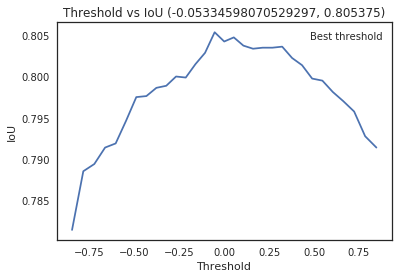

In [47]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [48]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [49]:
x_test = np.array([(np.array(load_img(path_test + "/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)



/usr/local/envs/py3env/lib/python3.5/site-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [50]:
preds_test = predict_result(model,x_test,img_size_target)

In [51]:

t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print("Usedtime = {0} s".format(t2-t1))

Usedtime = 6.358325719833374 s


In [52]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [ ]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")